In [1]:
import os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.spatial import KDTree
from scipy.interpolate import make_interp_spline
import fipy as fp
import gmsh
import timeit
from tqdm import tqdm

In [2]:
path='/home/artem.kays/scripts/lncRNAeffects/RNA_diffusion'
out_f = f'{path}/figures/3D_mesh_gen_test/sim_chrom'
os.chdir(path)
from utils.mesh_generation import *
from utils.graphics_3d import *

In [3]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=18
plt.rcParams['ytick.labelsize']=18
plt.rcParams['font.size']=18

In [55]:
def split_points_into_sets(points, sigma):
    n = len(points)
    if n < 3:
        return {'spline_sets': [], 'sphere_cylinder': list(range(n))}
    
    # Compute angles between consecutive segments for points 1 to n-2 (0-based)
    angles = []
    for i in range(1, n-1):
        vec_prev = np.array(points[i]) - np.array(points[i-1])
        vec_next = np.array(points[i+1]) - np.array(points[i])
        norm_prev = norm(vec_prev)
        norm_next = norm(vec_next)
        if norm_prev == 0 or norm_next == 0:
            # Handle zero-length segments (angle is 0)
            angles.append(0.0)
            continue
        cos_theta = np.dot(vec_prev, vec_next) / (norm_prev * norm_next)
        cos_theta = np.clip(cos_theta, -1.0, 1.0)
        theta = np.arccos(cos_theta)
        angles.append(theta)
    
    # Compute prefix sum of angles
    prefix_sum = [0.0]
    for angle in angles:
        prefix_sum.append(prefix_sum[-1] + angle)
    
    spline_sets = []
    sphere_cylinder = set()
    i = 0
    
    while i < n:
        j = i + 2
        while j < n:
            valid = True
            if j != i + 1:
                vec_prev = np.array(points[j-1]) - np.array(points[j-2])
                vec_next = np.array(points[j]) - np.array(points[j-1])
                norm_prev = norm(vec_prev)
                vec_next = norm(vec_next)
                thres = 1.3*sigma*np.sin(angles[j-2])
            if j != i + 1 and (norm_prev < thres or norm_next < thres):
                # print(i, j, norm_prev, vec_next, thres)
                break
            for k in range(i, j-1):
                cum_angle = prefix_sum[j-1] - prefix_sum[k]
                if cum_angle >= np.pi / 2:
                    point_k = np.array(points[k])
                    point_j = np.array(points[j])
                    dist = np.linalg.norm(point_k - point_j)
                    if dist <= 2 * sigma:
                        # print(i, j, k, dist)
                        valid = False
                        break
            if valid:
                j += 1
            else:
                break
        # Determine if the current segment is a valid spline set
        if j - i >= 3:
            spline_sets.append(list(range(i, j)))
            i = j - 1
        else:
            sphere_cylinder.add(i)
            i = j - 1
    
    # Convert the set to a sorted list
    sphere_cylinder = sorted(sphere_cylinder)
    
    return {
        'spline_sets': spline_sets,
        'sphere_cylinder': sphere_cylinder
    }

In [5]:
def gmsh_spline_with_volume_3d(points, sigma):
    # Create original spline
    p_tags = []
    # l_tags = []
    for i in range(len(points)):
        p_tags.append(gmsh.model.occ.addPoint(*points[i], 0))
        # if i:
        #     l_tags.append(gmsh.model.occ.addLine(p_tags[-2], p_tags[-1]))
    spline = gmsh.model.occ.addSpline(p_tags)
    
    #beg_circle = gmsh.model.occ.addDisk(*points[0], 0, 0.4*sigma*2, 0.4*sigma*2)
    #end_circle = gmsh.model.occ.addDisk(*points[-1], 0, 0.4*sigma*2, 0.4*sigma*2)

    # A wire is like a curve loop, but open:
    #wire = gmsh.model.occ.addWire(l_tags)
    wire = gmsh.model.occ.addWire([spline])
    
    # We define the shape we would like to extrude along the spline (a circle):
    disk = gmsh.model.occ.addDisk(*points[0], sigma, sigma)
    
    # Compute the axis of rotation (cross product of spline tangent and circle normal)
    spline_tan = points[1] - points[0]
    rotation_axis = np.cross(spline_tan, [0, 0, 1])
    rotation_axis /= np.linalg.norm(rotation_axis)
    
    # We use the dot product between the line vector and the z-axis to get the rotation angle
    angle = np.arcsin(np.abs(spline_tan[2]) / np.linalg.norm(spline_tan)) - np.pi / 2
    gmsh.model.occ.rotate([(2, disk)], *points[0], *rotation_axis, angle)
    
    # We extrude the disk along the spline to create a pipe (other sweeping types
    # can be specified; try e.g. 'Frenet' instead of 'DiscreteTrihedron'):
    chrom = gmsh.model.occ.addPipe([(2, disk)], wire, 'DiscreteTrihedron')
    gmsh.model.occ.remove([(1, spline)])
    gmsh.model.occ.remove([(2, disk)])

    return chrom

In [23]:
def chrom_3d(points, min_size, scale, sigma, mesh_f, space_scale=1.2, spheres=1, cylinders=1, splines=1):
    """
    Function creates circular 3D mesh with exclusion zone with no nodes and edges corresponding to chromatin.
    Mesh density is uniform in the region beyond the sigma*scale from the exclusion zone and
    follows a power-law dependence with an exponent of -2 within the sigma*scale from the exclusion zone

    **Input**

    -   points   =   Chromatin bins' coordinates
    -   sigma   =   Chromatin thickness (half-width of the exclusion zone with no nodes and edges)
    -   min_size    =   Mesh minimum density
    -   n_nodes    =   (Temporarily non-functional) Number of nodes (current function returns mesh with ~2-fold number of nodes)
    -   scale   =   Distance from the exclusion zone in sigma units within which mesh density
                    follows a power-law dependence with an exponent of -2
    -   output_dir    =   Output dir for mesh .msh2 file
    -   space_scale    =   Scaling factor of the convex hull of the chromatin bins
    """
    
    gmsh.initialize()
    gmsh.model.add("mesh")
    # gmsh.option.setNumber("General.Verbosity", 3)
    gmsh.option.setNumber("General.NumThreads", 16)
    gmsh.option.setNumber("Geometry.NumSubEdges", 1000)
    
    # Create main domain (scaled convex hull)
    # space, sp_vol = gmsh_convex_hull_3d(points, scale=space_scale)
    space = gmsh.model.occ.addBox(points[:,0].min()*2, points[:,1].min()*2, -2,
                                  (points[:,0].max()-points[:,0].min())*2,
                                  (points[:,1].max()-points[:,1].min())*2, 4)
    space = [(3, space)]

    # Create chromatin
    spline_sets = []
    if splines:
        sets = split_points_into_sets(points, sigma)
        spline_sets = sets['spline_sets']
        sphere_cylinder = sets['sphere_cylinder']
    else:
        sphere_cylinder = range(len(points))

    # splines_ = []
    chrom = []

    for i in sphere_cylinder:
        if spheres:
            chrom.append((3, gmsh.model.occ.addSphere(*points[i], 1.005*sigma)))
            # space = gmsh.model.occ.cut(space, [(3, gmsh.model.occ.addSphere(*points[i], 1.005*sigma))])[0]

    for spline in spline_sets:
        # space = gmsh.model.occ.cut(space, [(3, gmsh.model.occ.addSphere(*points[spline[0]], 1.005*sigma))])[0]
        chrom.append((3, gmsh.model.occ.addSphere(*points[spline[0]], 1.005*sigma)))
        chrom.extend(gmsh_spline_with_volume_3d(points[spline[0]:(spline[-1]+1)], sigma))
        # space = gmsh.model.occ.cut(space, gmsh_spline_with_volume_3d(points[spline[0]:(spline[-1]+1)], sigma))[0]
    
    dist = norm(points[1:]-points[:-1], axis=1)
    for i in sphere_cylinder:
        if i != len(points) - 1 and cylinders and dist[i] > (4*min_size*(2*sigma - min_size))**0.5/2:
            chrom.append((3, gmsh.model.occ.addCylinder(*points[i], *(points[i+1]-points[i]), sigma)))
            # space = gmsh.model.occ.cut(space, [(3, gmsh.model.occ.addCylinder(*points[i], *(points[i+1]-points[i]), sigma))])[0]

    chrom = gmsh.model.occ.fuse(chrom, chrom)[0]
    # print(gmsh.model.occ.getEntities(dim=3))
    space = gmsh.model.occ.cut(space, chrom)[0]
    # if splines_:
    #     space = gmsh.model.occ.cut(space, splines_)[0]
    gmsh.model.occ.synchronize()
    
    # (Temporarily non-functional) Evaluate min mesh size for generating required number of nodes
    # min_size=mesh_min_size_chrom_3d(points, n_nodes, sigma, scale, sp_vol)

    # Get chromatin surface
    s_tags=[s[1] for s in gmsh.model.occ.getEntities(dim=2) if gmsh.model.getType(*s) != 'Plane']
    
    # Configure mesh size field (graded from exclusion_radius)
    distance_field = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(distance_field, "FacesList", s_tags)
    
    # Use for large distances between adjacent bins
    # gmsh.model.mesh.field.setNumber(distance_field, "Sampling", 100)
    
    threshold_field = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(threshold_field, "InField", distance_field)
    gmsh.model.mesh.field.setNumber(threshold_field, "SizeMin", min_size)
    gmsh.model.mesh.field.setNumber(threshold_field, "SizeMax", min_size*scale**2)
    gmsh.model.mesh.field.setNumber(threshold_field, "DistMin", 0)
    gmsh.model.mesh.field.setNumber(threshold_field, "DistMax", sigma*scale)
    
    # Remove entities for cleaner mesh
    # gmsh.model.occ.remove(gmsh.model.occ.getEntities(dim=1))
    # gmsh.model.occ.remove(gmsh.model.occ.getEntities(dim=2))
    # gmsh.model.occ.synchronize()
    
    # Generate and save the mesh
    gmsh.model.mesh.field.setAsBackgroundMesh(threshold_field)
    gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
    gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
    gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)
    gmsh.option.setNumber("Mesh.Algorithm", 1)

    # This may resolve some BOPAlgo alerts and related errors
    # gmsh.model.mesh.generate(2)
    # gmsh.model.mesh.refine()
    
    gmsh.model.mesh.generate(3)
    gmsh.write(mesh_f)
    
    gmsh.finalize()

In [4]:
def mesh_triang(mesh, mask_z, mode_cells=1):
    if mode_cells:
        triang = tri.Triangulation(mesh.x.value[mask_z], mesh.y.value[mask_z])
        mask_b_1 = np.all(np.any(mesh.exteriorFaces.value[mesh.cellFaceIDs.data[:, mask_z]], axis=0)[triang.triangles], axis=1)
        mask_b_2 = (KDTree(bin_r).query(np.mean(mesh.cellCenters.value[:,mask_z].T[triang.triangles], axis=1))[0]<sigma)
        triang.set_mask(mask_b_1)# | mask_b_2)
        # triang.set_mask(mask_b)
    else:
        triang = tri.Triangulation(mesh.faceCenters.value[0], mesh.faceCenters.value[1])
        triang.set_mask(np.all(mesh.exteriorFaces.value[triang.triangles], axis=1))

    return triang

In [5]:
def plot_test_mesh(bin_r, min_size, scale, sigma, spheres, cylinders, splines):
    if not os.path.exists(f'{out_f}_tmp'):
        os.mkdir(f'{out_f}_tmp')
    print('Duration: ' + str(timeit.timeit(
          lambda: chrom_3d(bin_r, min_size, scale, sigma, f'{out_f}_tmp/3d_mesh_test.msh2',
                         spheres=spheres, cylinders=cylinders, splines=splines), number=1)
         ))
    mesh = fp.Gmsh3D(f'{out_f}_tmp/3d_mesh_test.msh2')
    print(f'mesh.cellCenters.shape: {mesh.cellCenters.shape}')

    plane_pos, thres = 0.5, min_size / 2
    plane = mesh.z.value.min() + plane_pos * (mesh.z.value.max() - mesh.z.value.min())
    mask_z = (abs(mesh.z.value - plane) < thres)

    triang = mesh_triang(mesh, mask_z, mode_cells=1)
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.triplot(triang, lw=0.1)
    plot_curve_with_opacity(ax, bin_r, z_plane=plane, num_segments=1, global_max=0, visibility=1)
    plt.scatter(bin_r[:, 0], bin_r[:, 1], s=5, c='black')
    
    ax.set_xlim(np.min(mesh.x.value[mask_z])*1.05, np.max(mesh.x.value[mask_z])*1.05)
    ax.set_ylim(np.min(mesh.y.value[mask_z])*1.05, np.max(mesh.y.value[mask_z])*1.05)
    ax.set_aspect('equal', adjustable='box')

    os.remove(f'{out_f}_tmp/3d_mesh_test.msh2')
    os.rmdir(f'{out_f}_tmp')

In [6]:
min_size, scale, sigma = 0.1, 5, 0.5

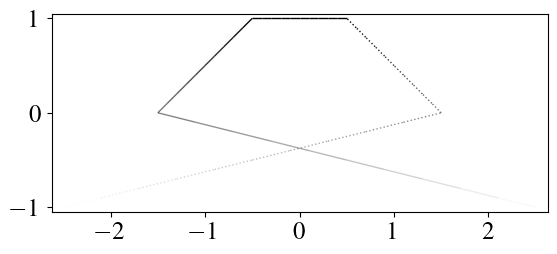

In [7]:
#ang, dspr = np.pi*1/4, 0.1
#r, ang = 1.3*sigma*np.sin(ang), np.pi - ang
#bin_r = [[dspr*r*np.cos(ang),dspr*r*np.sin(ang),0], [0,0,0], [1/dspr*r,0,0], [1/dspr*r-dspr*r*np.cos(ang),dspr*r*np.sin(ang),0]]

# bin_r = [[0,0,0],[1,2,0],[2,0,0],[3,2,0],[4,0,0],[5,2,0]]
bin_r = np.array([[0,0,-0.2],[4,1,-0.1],[3,2,0],[2,2,0],[1,1,0.1],[5,0,0.2]])
# bin_r[:, 1] *= 2
bin_r = (bin_r - np.mean(bin_r, axis=0))

fig, ax = plt.subplots()
plot_curve_with_opacity(ax, bin_r, z_plane=0, num_segments=10, global_max=0, visibility=0.95)
ax.set_xlim(np.min(bin_r[:, 0])*1.05, np.max(bin_r[:, 0])*1.05)
ax.set_ylim(np.min(bin_r[:, 1])*1.05, np.max(bin_r[:, 1])*1.05)
ax.set_aspect('equal', adjustable='box')

In [8]:
dist = norm(bin_r[1:]-bin_r[:-1], axis=1)
u_c = np.r_[0, np.cumsum(dist**0.5)]
spl = make_interp_spline(u_c, bin_r, axis=0)
uu = np.linspace(u_c[0], u_c[-1], len(dist)*10)
bin_r = spl(uu)

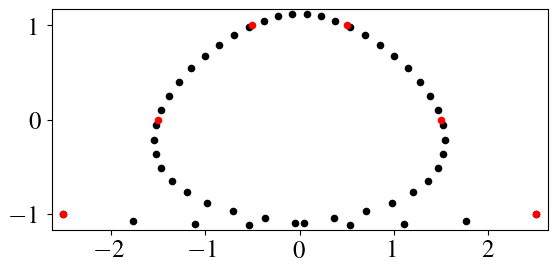

In [9]:
fig, ax = plt.subplots()
# plot_curve_with_opacity(ax, bin_r, z_plane=0, num_segments=1, global_max=0, visibility=0.95)
plt.scatter(bin_r[:, 0], bin_r[:, 1], s=20, c='black')
plt.scatter(spl(u_c)[:, 0], spl(u_c)[:, 1], s=20, c='r')
ax.set_xlim(np.min(bin_r[:, 0])*1.05, np.max(bin_r[:, 0])*1.05)
ax.set_ylim(np.min(bin_r[:, 1])*1.05, np.max(bin_r[:, 1])*1.05)
ax.set_aspect('equal', adjustable='box')

# fig.savefig(fname=f'{out_f}.svg', bbox_inches='tight', format='svg')
# fig.savefig(fname=f'{out_f}.png', bbox_inches='tight', dpi=300, format='png')

Text(0.5, 1.0, '$\\frac{angle}{\\pi}$ for adjacent interbin vectors')

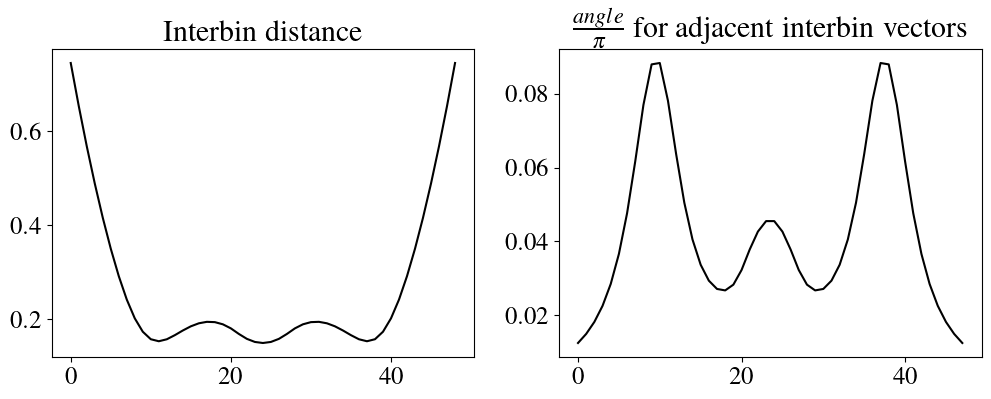

In [10]:
dist_r = bin_r[1:]-bin_r[:-1]
dist = norm(dist_r, axis=1)
cos_ = (dist_r[:-1] * dist_r[1:]).sum(1) / dist[:-1] / dist[1:]
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(dist, c='black')
ax[0].set_title('Interbin distance')
ax[1].plot(np.arccos(cos_) / np.pi, c='black')
ax[1].set_title(r'$\frac{angle}{\pi}$ for adjacent interbin vectors')

# fig.savefig(fname=f'{out_f}_geom.svg', bbox_inches='tight', format='svg')
# fig.savefig(fname=f'{out_f}_geom.png', bbox_inches='tight', dpi=300, format='png')

Info    : Meshing 1D...                                                                                                                        
Info    : [  0%] Meshing curve 13 (Circle)
Info    : [  0%] Meshing curve 17 (Circle)
Info    : [  0%] Meshing curve 15 (Circle)
Info    : [  0%] Meshing curve 14 (Circle)
Info    : [  0%] Meshing curve 22 (Line)
Info    : [  0%] Meshing curve 18 (Circle)
Info    : [  0%] Meshing curve 23 (BSpline)
Info    : [  0%] Meshing curve 24 (BSpline)
Info    : [  0%] Meshing curve 25 (BSpline)
Info    : [  0%] Meshing curve 26 (Circle)
Info    : [  0%] Meshing curve 27 (Circle)
Info    : [  0%] Meshing curve 28 (Circle)
Info    : [  0%] Meshing curve 30 (Circle)
Info    : [  0%] Meshing curve 20 (Circle)
Info    : [  0%] Meshing curve 31 (Circle)
Info    : [  0%] Meshing curve 32 (Circle)
Info    : [  0%] Meshing curve 34 (Circle)
Info    : [  0%] Meshing curve 36 (Circle)
Info    : [  0%] Meshing curve 37 (Circle)
Info    : [  0%] Meshing curve 21 (BSp

Info    : [  0%] Meshing surface 50 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 51 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 52 (Cylinder, MeshAdapt)
Info    : [  0%] Meshing surface 53 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 54 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 55 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 56 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 57 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 58 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 59 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 60 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 61 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 62 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 63 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 64 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 65 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 66 (Sphere, MeshAdapt)
Info    : [  0%] Meshing surface 67 (Sphere, M

Info    : Done writing '/home/artem.kays/scripts/lncRNAeffects/RNA_diffusion/figures/3D_mesh_gen_test/sim_chrom_tmp/3d_mesh_test.msh2'
Duration: 49.58068315312266
mesh.cellCenters.shape: (3, 23473)


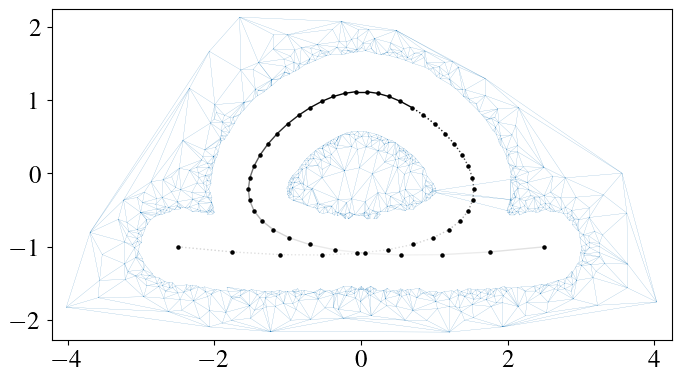

In [25]:
plot_test_mesh(bin_r, min_size, scale, sigma=0.5, spheres=1, cylinders=1, splines=0)

In [107]:
gmsh.finalize()

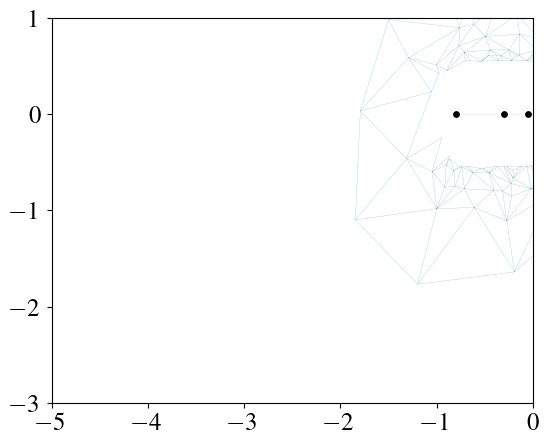

In [31]:
triang = mesh_triang(mesh, mask_z, mode_cells=1)

fig, ax = plt.subplots(figsize=(8,5))
ax.triplot(triang, lw=0.1)
plot_curve_with_opacity(ax, bin_r, z_plane=plane, num_segments=1, global_max=0, visibility=1)
plt.scatter(bin_r[:, 0], bin_r[:, 1], s=15, c='black')

ax.set_xlim(-5, 0)
ax.set_ylim(-3, 1)
ax.set_aspect('equal', adjustable='box')

# fig.savefig(fname=f'{out_f}_spheres.svg', bbox_inches='tight', format='svg')
# fig.savefig(fname=f'{out_f}_spheres.png', bbox_inches='tight', dpi=300, format='png')

In [ ]:
KDTree(bin_r).query
ext_faces=mesh.faceCenters.value.T[mesh.exteriorFaces]
chr_faces=KDTree(ext_faces[ext_faces[:,0]**2+ext_faces[:,1]**2<(radius/1.1)**2])
d_chr = fp.CellVariable(mesh=mesh, name=r'$d_{chr}$', value = chr_faces.query(mesh.cellCenters.value.T)[0] + sigma_chr)